In this kernel I present a very simple K-nearest neighbors model based on the quantiles of the distribution. Although simple, the model does quite well.  It might be possible to include the predictions from this model as a feature in some other model or they could be used as part of model averaging.  Enjoy!

First load in the data and required packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test', 'sample_submission.csv', 'train.csv']


In [3]:
## Read in the data
eq = pd.read_csv("../input/train.csv", dtype={'acoustic_data': np.int16,
                                     'time_to_failure': np.float64})
## Print the first five lines
print(eq.head(5))

   acoustic_data  time_to_failure
0             12           1.4691
1              6           1.4691
2              8           1.4691
3              5           1.4691
4              8           1.4691


Here we take the raw values of the acoustic data, sort them, and average over every 100 values.  

In [8]:
## Number of rows for each segment
rows = 150000
## Get the number of segments
segments = int(np.floor(eq.shape[0] / rows))
## Initialize X values and y values
X_train = pd.DataFrame(index=range(segments), dtype=np.float64, columns=range(0,1500))
y_train = pd.DataFrame(index=range(segments), dtype=np.float64, columns=['time_to_failure'])
## Create features for each segment
for seg_id in tqdm(range(segments)):
    ## Get segment values
    seg = eq.iloc[range((seg_id*rows),((seg_id+1)*rows))]
    ## Sort the values
    x = np.sort(seg['acoustic_data'].values)
    ## Sum values of the quantile and put in X matrix
    X_train.loc[seg_id,:] = np.reshape(x, (-1, 100)).sum(axis=-1)
    ## Get the time to failure of final observation
    y_train.loc[seg_id, 'time_to_failure'] = seg['time_to_failure'].values[-1];

y_train = np.ravel(y_train);

100%|██████████| 4194/4194 [02:31<00:00, 27.73it/s]


Let's plot some of the quantiles against the time to failure.  Each of the quantiles appears to contain some sort of information.

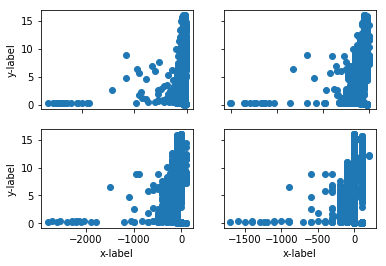

In [14]:
f, axarr = plt.subplots(2, 2)
axarr[0, 0].scatter(X_train.iloc[:,0], y_train)
axarr[0, 1].scatter(X_train.iloc[:,50], y_train)
axarr[1, 0].scatter(X_train.iloc[:,100], y_train)
axarr[1, 1].scatter(X_train.iloc[:,149], y_train)
for ax in axarr.flat:
    ax.set(xlabel='Quantile Sum', ylabel='Time to failure')
for ax in axarr.flat:
    ax.label_outer()

Here we perform 5-fold cross validation of a KNN model after using a standard scaler.

In [17]:
## Create pipline for cross validation using the standard scaler
knn_pl = make_pipeline(preprocessing.StandardScaler(),
                       neighbors.KNeighborsRegressor(500, weights='uniform', metric='manhattan'))
## Perform 5 fold cross validation
scores = cross_val_score(knn_pl, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
np.mean(scores)

-2.160673089320833

We get a cross validation score of 2.16. Not bad for such a simple model!

In [21]:
knn_final = neighbors.KNeighborsRegressor(500, weights='uniform', metric='manhattan')
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
knn_final.fit(scaler.transform(X_train), y_train)

submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id')
X_test = pd.DataFrame(dtype = np.float64, index = submission.index,columns=range(0,1500))
for seg_id in tqdm(X_test.index):
    seg = pd.read_csv('../input/test/' + seg_id + '.csv')
    xc = np.sort(seg['acoustic_data'].values)
    X_test.loc[seg_id,:] = np.reshape(xc, (-1, 100)).sum(axis=-1)

submission['time_to_failure'] = knn_final.predict(scaler.transform(X_test))
print(submission.head(5))

submission.to_csv('knn_std.csv')

100%|██████████| 2624/2624 [00:56<00:00, 42.58it/s]


            time_to_failure
seg_id                     
seg_00030f         4.554798
seg_0012b5         5.317521
seg_00184e         5.456752
seg_003339         8.516055
seg_0042cc         6.379061
